In [1]:
import os
from os.path import join
import pandas as pd
from tqdm import tqdm
from geopy.geocoders import Nominatim
from statistics import mean
import numpy as np
from matplotlib import pyplot as plt
import math
import json

In [2]:
def get_locations(address, zip_code):
    try:
        # This removes information about a flats storey
        address_field = address.split(', ')[0]
        # This one removes trailing letters on the city name
        # It seems as if Openstreetmap cannot handle København H
        # but it works with København
        zip_field = ' '.join(zip_code.split(' ')[:-1])
        search_address = ', '.join([address_field, zip_field])

        geolocator = Nominatim()
        location = geolocator.geocode(search_address)
        return location.latitude, location.longitude
    except:
        print('Skipped geocoding of {} {}'.format(address, zip_code))
        return None, None

In [3]:
def haversine_distance(origin, destination):

    lat_orig, lon_orig = origin
    lat_dest, lon_dest = destination
    radius = 6371

    dlat = math.radians(lat_dest-lat_orig)
    dlon = math.radians(lon_dest-lon_orig)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat_orig)) 
        * math.cos(math.radians(lat_dest)) * math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [4]:
def remove_city_name(zip_code):
    return str(zip_code.split(' ')[0])

In [5]:
def create_data_frame():
    li = []
    for filename in os.listdir('./boliga_stats'):
        #filename = os.path.join(os.getcwd(),filename)
        df = pd.read_csv(os.path.join('./boliga_stats',filename), index_col=None, header=0)
        li.append(df)

    return pd.concat(li, axis=0, ignore_index=True)

In [45]:
def create_city_csv(dataframe, year):
    cities = {
              'Odense': '5000',
              'København': '1050',
              'Aarhus': '8000',
              'Aalborg': '9000'}
    folder_path = join(os.getcwd(),year)          
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        
    for city in cities:
        mask = ((dataframe['zip_code_num'] == cities[city]) & (df['sell_date'].dt.year == int(year)))
        dataf = dataframe[mask]
        dataf.to_csv('./' + year + '/' + city + ".csv", index=False,encoding='utf-8')

In [40]:
def calulate_avg_year(df,mask,year,zipcode):
    temp = df[mask]
    temp = temp.dropna(subset=['price_per_sq_m'])
    if not temp.empty:
        #print('Average price per square meter for the zip code {} in the year {} is {} pr. m\u00b2\n'.format(
          #  zipcode,year,mean(temp['price_per_sq_m'])))
        return mean(temp['price_per_sq_m'])
    else:
        #print('Average price per square meter for the zip code {} in the year {} is {} pr. m\u00b2\n'.format(
         #   zipcode,year,0))
        return 0
    

In [8]:
def get_number_and_street(address):
    street = ''
    house_number = '' 
    is_number = False
    for elem in address:
        if is_number:
            if not elem.isnumeric():
                if elem not in [',','.',' ']:
                    house_number+=elem
                    break
                break    
            house_number+=elem
        elif elem.isnumeric():
            is_number = True
            house_number+=elem
        else:
            street+=elem      
    return  street.strip(),house_number.strip()       
        
        

In [9]:
def get_geo_code(address,zip_code,geo_codes):
    street, house_number = get_number_and_street(address)
    try:
        _zip_code = geo_codes[zip_code]
        if street in _zip_code:
            _street = _zip_code[street]
            if house_number in _street:
                return tuple(_street[house_number])
        if len(_zip_code.keys()) == 1:
            key = next(iter(_zip_code))   
            return tuple(_zip_code[key][house_number])
        elif house_number in _zip_code:
            return tuple(_zip_code[house_number])
        else:
            return (None,None)
    except Exception as e:
        print('Key {} not found. Address was {} {} {}'.format(e,street,house_number,zip_code))
        return (None,None)

### Read the entire dataset of Danish housing sales data, from Boliga

In [10]:
# creates the dataframe.
df = create_data_frame()

In [11]:
# Create a  new column which only contain the zip code.
df['zip_code_num'] = df.apply(lambda x: remove_city_name(x['zip_code']), axis=1)

In [12]:
df.head()

,address,zip_code,price,sell_date,sell_type,price_per_sq_m,no_rooms,housing_type,size_in_sq_m,year_of_construction,price_change_in_pct,zip_code_num
0,Nykøbingvej 23,4460 Snertinge,150000,05-04-2017,Alm. Salg,1209.0,4.0,Villa,124.0,1934.0,0.0,4460
1,Bakkekammen 5,4460 Snertinge,1145000,24-03-2017,Alm. Salg,9015.0,3.0,Villa,127.0,1971.0,-4.0,4460
2,Æblekjærvej 11,4460 Snertinge,700000,15-02-2017,Alm. Salg,6666.0,3.0,Villa,105.0,1946.0,-12.0,4460
3,Bakkekammen 7,4460 Snertinge,920000,30-01-2017,Alm. Salg,8518.0,4.0,Villa,108.0,1966.0,-3.0,4460
4,Tværvej 4,4460 Snertinge,300000,01-12-2016,Alm. Salg,3061.0,3.0,Villa,98.0,1964.0,0.0,4460


### Geocode the the entire dataset of Danish housing sales data

We read the file containg the geocodes.

In [14]:
with open('./data/postcodes.json') as fil:
     data = json.load(fil)

We find the longitude and latitude for all of the adresses.

In [15]:
df['long'],df['lat'] = zip(*df.apply(lambda row : get_geo_code(row['address'],row['zip_code_num'],data), axis=1))

In [16]:
# removing values where the lattitude and longitude is None.
df = df.dropna()

In [18]:
df.to_csv('./house_sale_data_with_geocodes.csv', index=False,encoding='utf-8')

### Convert all sales dates in the dataset into proper datetime objects

In [26]:
df['sell_date'] = pd.to_datetime(df['sell_date'],format='%d-%m-%Y')

### Compute the average price per square meter for the years 1992 and 2016

In [27]:
#Generate the masks we need. 
mask_1992 = ((df['sell_date'].dt.year == 1992) & 
     ((df['zip_code_num'] == '1050') | (df['zip_code_num'] == '1049') | (df['zip_code_num'] == '5000') | 
     (df['zip_code_num'] == '8000') | (df['zip_code_num'] == '9000'))
     )


mask_2016 = ((df['sell_date'].dt.year == 2016) & 
     ((df['zip_code_num'] == '1050') | (df['zip_code_num'] == '1049') | (df['zip_code_num'] == '5000') | 
     (df['zip_code_num'] == '8000') | (df['zip_code_num'] == '9000'))
     )


mask_1992_1050_1049 = ((df['sell_date'].dt.year == 1992) & 
     ((df['zip_code_num'] == '1050') | (df['zip_code_num'] == '1049')))

mask_1992_5000 = ((df['sell_date'].dt.year == 1992) & 
     ((df['zip_code_num'] == '5000')))  
                  
mask_1992_8000 = ((df['sell_date'].dt.year == 1992) & 
     ((df['zip_code_num'] == '8000')))    

mask_1992_9000 = ((df['sell_date'].dt.year == 1992) & 
     ((df['zip_code_num'] == '9000')))


mask_2016_1050_1049 = ((df['sell_date'].dt.year == 2016) & 
     ((df['zip_code_num'] == '1050') | (df['zip_code_num'] == '1049')))

mask_2016_5000 = ((df['sell_date'].dt.year == 2016) & 
     ((df['zip_code_num'] == '5000')))

mask_2016_8000 = ((df['sell_date'].dt.year == 2016) & 
     ((df['zip_code_num'] == '8000')))

mask_2016_9000 = ((df['sell_date'].dt.year == 2016) & 
     ((df['zip_code_num'] == '9000')))

                  

In [28]:
masks = [
    (mask_1992_1050_1049,'1050-1049','1992'),
    (mask_1992_5000,'5000','1992'),
    (mask_1992_8000,'8000','1992'),
    (mask_1992_9000,'9000','1992'),
    (mask_2016_1050_1049,'1050-1049','2016'),
    (mask_2016_5000,'5000','2016'),
    (mask_2016_8000,'8000','2016'),
    (mask_2016_9000,'9000','2016')
]

Here we calcualte the average prices for 1992 and 2016.

In [43]:
list_1992 = []
list_2016 = []
for mask,zip_code,year in masks:
    avg_sqr_price = calulate_avg_year(df,mask,year,zip_code)
    if year == '1992':
        list_1992.append((zip_code,avg_sqr_price))
    else:
        list_2016.append((zip_code,avg_sqr_price))

df_2016 = pd.DataFrame(list_2016,columns=['zipcode', 'avg_sqr_m_price'])
df_1992 = pd.DataFrame(list_1992,columns=['zipcode', 'avg_sqr_m_price'])

### Create, with the help of the pandas module, four new CSV files containing the sales data for the year 1992 for the city centers of Copenhagen (zip code 1050-1049), Odense (zip code 5000), Aarhus (zip code 8000), and Aalborg (zip code 9000)

In [48]:
# Creates a folder called 1992 and creates 4 csv files.
create_city_csv(df, '1992')

### Create a 2-dimensional scatter plot, which contains a dot for each location in the dataset of Danish housing sales data. Plot the longitude values on the x- axis and plot the latitude values on the y-axis.

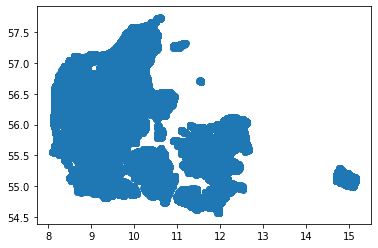

In [49]:
%matplotlib inline
plt.scatter(df['long'],df['lat'])
plt.savefig('plot-1.png')

### computes the Haversine Distance

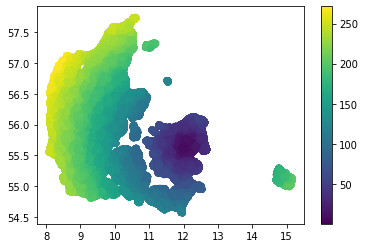

In [50]:
distances = []
for i in zip(df.lat,df.long):
    distances.append(haversine_distance(i,(55.65, 12.083333)))
plt.scatter(df.long,df.lat,c=distances) 
plt.colorbar()
plt.savefig('plot-2.png')